#  Project: Diabetes trials study on ClinicalTrials.gov
## Use diabetes trials' start_date to predict the trend of diabetes clinical study 
1. extract and cataloged diabetes trials data into dataframe;

2. plot the tendency curves for diabetes trials;

3. implement time series analysis ARIMA model to predict the trend;


In [40]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import time

In [41]:
dfID1= pd.read_csv("Diabetes_trial.csv")
dfID1.head()

,nct_id,nct_date,nct_year
0,NCT00000620,Sep-99,1999
1,NCT00001853,6-Oct-98,1998
2,NCT00001870,Jan-99,1999
3,NCT00001985,Jan-00,2000
4,NCT00001987,30-Jan-76,1976


In [42]:
def yearextract(start_datelist):
    start_yearlist=[]
    for i in range(len(start_datelist)):
        rawdate=start_datelist[i]
        #print(rawdate)
        if pd.isnull(rawdate):
            datetest1 = None
            #datetest1 = NaN
        else:
            datetest1=int(rawdate.split(" ")[-1])
        start_yearlist.append(datetest1)
    return start_yearlist

1976 2019


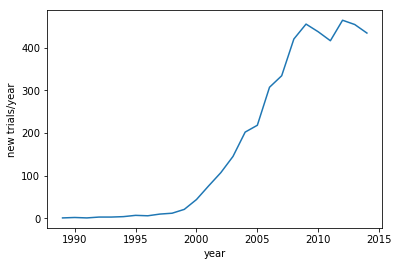

In [43]:
xyear=np.arange(1984,2020)
print(dfID1.nct_year.min(),dfID1.nct_year.max())
#print(xyear)
histy,binsx=np.histogram(dfID1.nct_year, bins=xyear)
trialsNt=histy[5:-4]
yearst=xyear[5:-5]
plt.figure()
plt.plot(yearst,trialsNt)
plt.xlabel('year')
plt.ylabel('new trials/year')
plt.show()


In [44]:
#make a new dataframe only have two column: nct_title; nct_date;
dfID2= pd.DataFrame(index=range(0,len(yearst)), columns=['years_t','trialsN_t','log_trialsN'])
#add disease names then it is done!
dfID2.years_t=yearst
dfID2.trialsN_t=trialsNt.astype(float)+200#for log
dfID2.log_trialsN= np.log(dfID2.trialsN_t)
print(dfID2.shape)

dfID2.index=yearst
dfID2.index=pd.to_datetime(dfID2.index, format='%Y')
#for time series analysis index must be date
dfID2.head()

(26, 3)


,years_t,trialsN_t,log_trialsN
1989-01-01,1989,201.0,5.303305
1990-01-01,1990,202.0,5.308268
1991-01-01,1991,201.0,5.303305
1992-01-01,1992,203.0,5.313206
1993-01-01,1993,203.0,5.313206


In [45]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

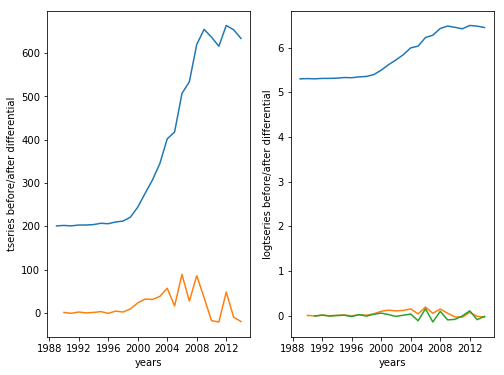

In [52]:
#test the differencing order
tseries=dfID2.trialsN_t
tseries_diff=tseries - tseries.shift()
tseries_diff.dropna(inplace=True)
log_tseries=dfID2.log_trialsN
log_tseries_diff=log_tseries - log_tseries.shift()
log_tseries_diff.dropna(inplace=True)
log_tseries_diff_diff=log_tseries_diff- log_tseries_diff.shift()
log_tseries_diff_diff.dropna(inplace=True)
#print(log_tseries_diff)
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121)
ax1.plot(tseries)
ax1.plot(tseries_diff)
ax1.set_xlabel('years')
ax1.set_ylabel('tseries before/after differential')
#ax1.plot(log_tseries_diff_diff)
ax2 = fig.add_subplot(122)
ax2.plot(log_tseries)
ax2.plot(log_tseries_diff)
ax2.plot(log_tseries_diff_diff)
ax2.set_xlabel('years')
ax2.set_ylabel('logtseries before/after differential')
plt.show()

In [53]:
dftest = adfuller(log_tseries_diff, autolag='AIC')# from statsmodels.tsa.stattools package;
#Augmented Dickey-Fuller unit root test
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_output(dftest)

Test Statistic                 -4.358141
p-value                         0.000352
# of Lags Used                  9.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (10%)           -2.681814
Critical Value (5%)            -3.084908
dtype: float64


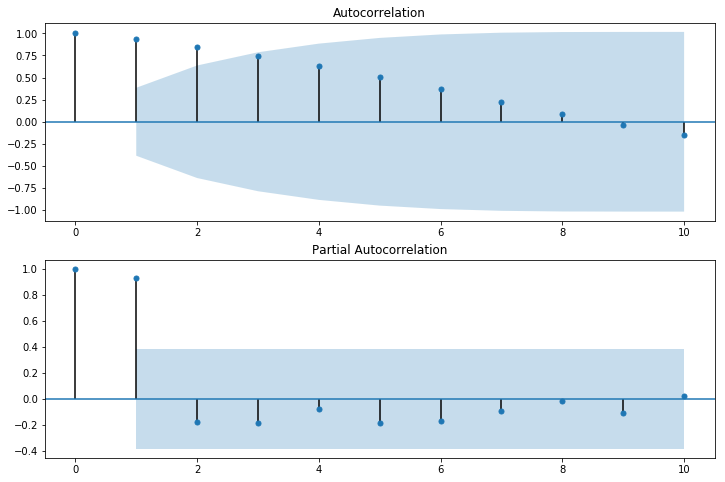

In [54]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(log_tseries, ax=ax1, lags=10, alpha=0.05)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(log_tseries, ax=ax2, lags=10, alpha=0.05)
plt.show()
#ARIMA(p,I,q)
#based on adfuller, acf and pacf test: the inital guess for p,I,q=2,1,0

                             ARIMA Model Results                              
Dep. Variable:          D.log_trialsN   No. Observations:                   25
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  38.417
Method:                       css-mle   S.D. of innovations              0.051
Date:                Sun, 16 Apr 2017   AIC                            -66.834
Time:                        20:22:16   BIC                            -60.740
Sample:                    01-01-1990   HQIC                           -65.144
                         - 01-01-2014                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0328      0.031      1.074      0.295      -0.027       0.093
ar.L1.D.log_trialsN     0.3356      0.366      0.917      0.370      -0.382       1.053
ar.L2.D.log_tria

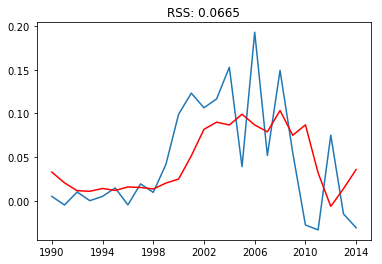

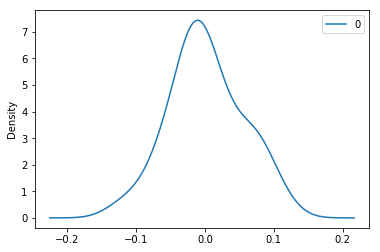

               0
count  25.000000
mean    0.001763
std     0.052595
min    -0.114775
25%    -0.027002
50%    -0.003916
75%     0.026758
max     0.106269


In [55]:
# fit model
model1 = ARIMA(log_tseries, order=(2,1,1))
#about how to determine the value for AR and AM
model_fit1 = model1.fit(disp=0)
print(model_fit1.summary())
plt.plot(log_tseries_diff)
plt.plot(model_fit1.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((model_fit1.fittedvalues-log_tseries_diff)**2))
plt.show()
residuals = pd.DataFrame(model_fit1.resid)
residuals.plot(kind='kde')#pandas.data frame can plot...
plt.show()
print(residuals.describe())

In [56]:
X = log_tseries.values
size = int(len(X) * 0.6)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat) #each time only predict one point, and training data(history) keep updated!
    #the ARIMA model is keep been updated, step by step predication
    obs = test[t]
    history.append(obs)#it keep updated
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=5.953942, expected=5.996452
predicted=6.150920, expected=6.035481
predicted=6.074289, expected=6.228511
predicted=6.290349, expected=6.280396
predicted=6.439148, expected=6.429719
predicted=6.493387, expected=6.484635
predicted=6.609824, expected=6.456770
predicted=6.490993, expected=6.423247
predicted=6.408608, expected=6.498282
predicted=6.516401, expected=6.483107
predicted=6.528962, expected=6.452049
Test MSE: 0.007


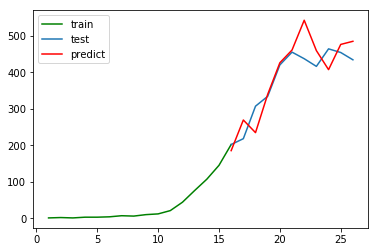

In [57]:
# plot step by step predication
train1=X[0:size+1]
trainx=list(range(1,len(train1)+1))
testx=list(range(trainx[-1],len(test)+trainx[-1]))
plt.plot(trainx, np.exp(train1)-200, color='green', label='train')
plt.plot(testx, np.exp(test)-200, label='test')
plt.plot(testx, np.exp(predictions)-200, color='red', label='predict')
plt.legend()
plt.show()


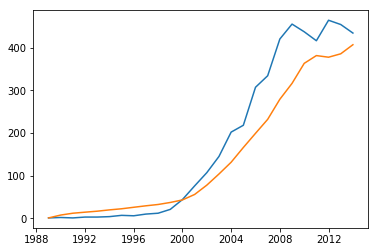

In [58]:
# use the integration of fittedvalues to predict the whole curves.
predictions_ARIMA_diff1 = pd.Series(model_fit1.fittedvalues, copy=True)
#print(predictions_ARIMA_diff1.head())
predictions_ARIMA_diff1_cumsum = predictions_ARIMA_diff1.cumsum()
#print(predictions_ARIMA_diff1_cumsum.head())
predictions_ARIMA_log = pd.Series(log_tseries.ix[0], index=log_tseries.index)#train data
#print(predictions_ARIMA_log.head())
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff1_cumsum,fill_value=0)
#print(predictions_ARIMA_log.head())
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(tseries.add(-200))
plt.plot(predictions_ARIMA.add(-200))
plt.show()